In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pprint import pprint
from sqlalchemy import create_engine
import os

plt.style.use('ggplot')
plt.figure(figsize=(12,8), dpi= 100)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

start_date = '2018-11-26' # the datasets start from this date
split_date = '2020-12-25' # the date for train test split
test_start = start_date # the start date for the testset. this is
                          # in case we want a longer testing period
                          # than the train test split
test_end = (datetime.strptime(split_date, '%Y-%m-%d').date()+timedelta(180)).strftime('%Y-%m-%d') # 

<Figure size 1200x800 with 0 Axes>

## Define Helper functions

In [2]:
def generate_roi(asset_weights, assets_df, plot=True, rebalance_period=1):
    """
    given the asset weights, generate the return on $100 initial investment
    rebalances on the first day of each rebalance_period
    """
    investment_total = 100
    asset_allocation = {
        asset: investment_total * weight for asset, weight in asset_weights.items()
    }
    investment_daily_value = [investment_total]
    for i in range(len(assets_df) - 1):
        for asset, weight in asset_weights.items():
            asset_price_today = assets_df[asset][i]
            asset_price_next_day = assets_df[asset][i + 1]
            asset_allocation[asset] *= asset_price_next_day / asset_price_today
        investment_total = sum(asset_allocation.values())
        investment_daily_value.append(investment_total)
        if rebalance_period > 0 and i % rebalance_period == 0:
            asset_allocation = {
                asset: investment_total * weight for asset, weight in asset_weights.items()
            }

    roi = [dv - 100 for dv in investment_daily_value]
    if plot:
        plt.plot(assets_df.index, roi, "--", label="portfolio")
        plt.annotate(text="portfolio", xy=(assets_df.index[-1], roi[-1]), fontsize=8)
        for asset in assets_df.columns:
            roi_asset = (assets_df[asset] / assets_df[asset][0]) * 100 - 100
            x, y = assets_df.index, roi_asset
            plt.plot(x, y, label=asset)
            plt.annotate(text=asset, xy=(x[-1], y[-1]), fontsize=8)
            plt.ylabel("apy %")
    #             plt.legend()
    return roi


def evaluation(weights, assets_df, rebalance_period=1):
    # expected return
    mu = mean_historical_return(assets_df, frequency=365)
    # covariance matrix
    S = risk_matrix(assets_df, method='ledoit_wolf', frequency=365)
    _ = portfolio_performance(
        weights, mu, S, verbose=True, risk_free_rate=0.02
    )
    roi = generate_roi(weights, assets_df, plot=True, rebalance_period=rebalance_period)
    return roi
    

    
def optimize_portfolio(train_df, test_df, rebalance_period, target_volatility=None, constraints_fn=None):
    # expected return
    mu = mean_historical_return(train_df, frequency=365)
    # covariance matrix
    S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
    print("mean (yearly) return:")
    print(mu)
    ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
    # add the constraints
    constraints_fn(ef, train_df)
    if target_volatility is None:
        weights = ef.min_volatility()
    else:
        weights = ef.efficient_risk(target_volatility=target_volatility)
    print("\n---portfolio weights---")
    pprint(ef.clean_weights())
    print("\n")
    _ = evaluation(weights, train_df, rebalance_period=rebalance_period)
    plt.title("Training set performance")
    plt.show()
    roi = evaluation(weights, test_df)
    plt.title(f"APY vs time. Test period: {split_date}-{test_end}")
    plt.show()
    print("return in the test period", roi[-1])
    return ef.clean_weights(), roi    

In [3]:
# asset_prices_df = pd.read_csv("../data/clean_data/asset_prices_2021-07-08.csv", index_col=0)
engine = create_engine(os.environ.get("POSTGRES_REMOTE_URL"))
asset_prices_df = pd.read_sql_table("asset_price", engine)
# convert data from long to wide format
asset_prices_df = asset_prices_df.pivot(
    index="timestamp", columns="asset_ticker", values="closing_price"
)
asset_prices_df.index = [pd.to_datetime(t).date() for t in asset_prices_df.index]
asset_prices_df.tail(10)

asset_ticker,aave,ada,bch,bnb,bsv,btc,c.r.e.a.m.-finance,compound,definer,doge,...,neo,okb,theta,trx,usdc,usdt,vet,xlm,xmr,xrp
2021-08-21,1.172799,2.175253,670.913397,417.986906,163.514293,46519.492505,1.255537,1.136638,1.074540,0.313598,...,54.990596,21.851641,7.217882,0.088939,0.999850,1.002000,0.128314,0.370016,266.614250,1.206362
2021-08-22,1.172882,2.210967,669.567142,423.819596,163.655846,46783.040507,1.255761,1.136704,1.074625,0.317084,...,54.962215,21.681561,7.225530,0.088277,0.999621,1.002052,0.128093,0.367107,269.047072,1.198208
2021-08-23,1.172967,2.281768,665.162497,428.847183,163.122459,47100.975027,1.255975,1.136770,1.074708,0.313644,...,54.442632,21.509465,7.208529,0.087556,0.999713,1.002684,0.126661,0.364284,273.769486,1.190047
2021-08-24,1.173057,2.401074,665.391475,440.666875,163.186896,47599.092162,1.256182,1.136837,1.074791,0.313275,...,55.056265,21.450869,7.240370,0.087587,0.999721,1.002721,0.126958,0.364989,280.987163,1.198174
2021-08-25,1.173141,2.518617,664.732120,450.832168,163.559299,48085.685456,1.256389,1.136906,1.074881,0.312082,...,55.655016,21.487206,7.258072,0.087571,1.000062,1.002793,0.127797,0.366922,288.422318,1.205516
2021-08-26,1.173224,2.607111,666.128628,465.395228,164.503627,48655.290916,1.256587,1.136977,1.074971,0.310382,...,56.267381,21.593185,7.301079,0.087892,1.000215,1.002615,0.128725,0.368943,296.864579,1.207655
2021-08-27,1.173303,2.648241,660.446028,473.014069,164.099536,48724.438920,1.256775,1.137048,1.075062,0.304542,...,56.079050,21.356779,7.238380,0.087428,0.999818,1.000961,0.127487,0.365533,301.752112,1.194836
2021-08-28,1.173385,2.716627,652.008805,478.865679,162.463589,48708.328164,1.256959,1.137120,1.075155,0.299765,...,55.950549,21.142827,7.191276,0.087179,0.999818,1.000994,0.126574,0.361478,306.434727,1.183715
2021-08-29,1.173466,2.775562,647.411162,484.002926,162.069560,48708.735036,1.257138,1.137194,1.075247,0.295347,...,55.802054,21.019563,7.140617,0.087238,1.000416,1.001049,0.125764,0.358054,308.156089,1.173536
2021-08-30,1.173544,2.796787,644.028316,487.728980,162.269476,48555.745923,1.257312,1.137267,1.075340,0.290354,...,55.284378,20.864135,7.038616,0.087254,1.000752,1.000447,0.124762,0.353777,306.455269,1.160815


## Lending Protocol Portfolio

In [4]:
lp_returns_df = asset_prices_df[["aave", "compound", "dydx", "definer", "c.r.e.a.m.-finance"]]
train_df = lp_returns_df[lp_returns_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = lp_returns_df[(lp_returns_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (lp_returns_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

lp_returns_df.tail()


asset_ticker,aave,compound,dydx,definer,c.r.e.a.m.-finance
2021-08-26,1.173224,1.136977,1.163915,1.074971,1.256587
2021-08-27,1.173303,1.137048,1.164022,1.075062,1.256775
2021-08-28,1.173385,1.137120,1.164131,1.075155,1.256959
2021-08-29,1.173466,1.137194,1.164242,1.075247,1.257138
2021-08-30,1.173544,1.137267,1.164354,1.075340,1.257312


mean (yearly) return:
asset_ticker
aave                  0.064319
compound              0.049028
dydx                  0.051480
definer               0.024091
c.r.e.a.m.-finance    0.081171
dtype: float64

---portfolio weights---
OrderedDict([('aave', 0.3),
             ('compound', 0.1),
             ('dydx', 0.2),
             ('definer', 0.1),
             ('c.r.e.a.m.-finance', 0.3)])


Expected annual return: 6.1%
Annual volatility: 0.1%
Sharpe Ratio: 66.42


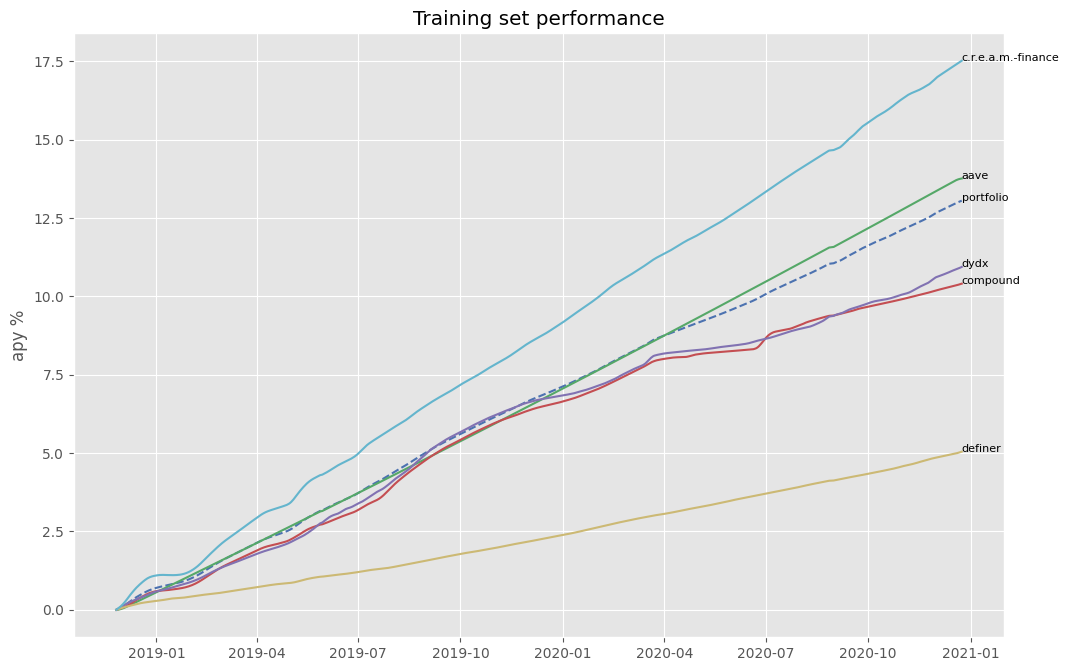

Expected annual return: 6.5%
Annual volatility: 0.1%
Sharpe Ratio: 49.74


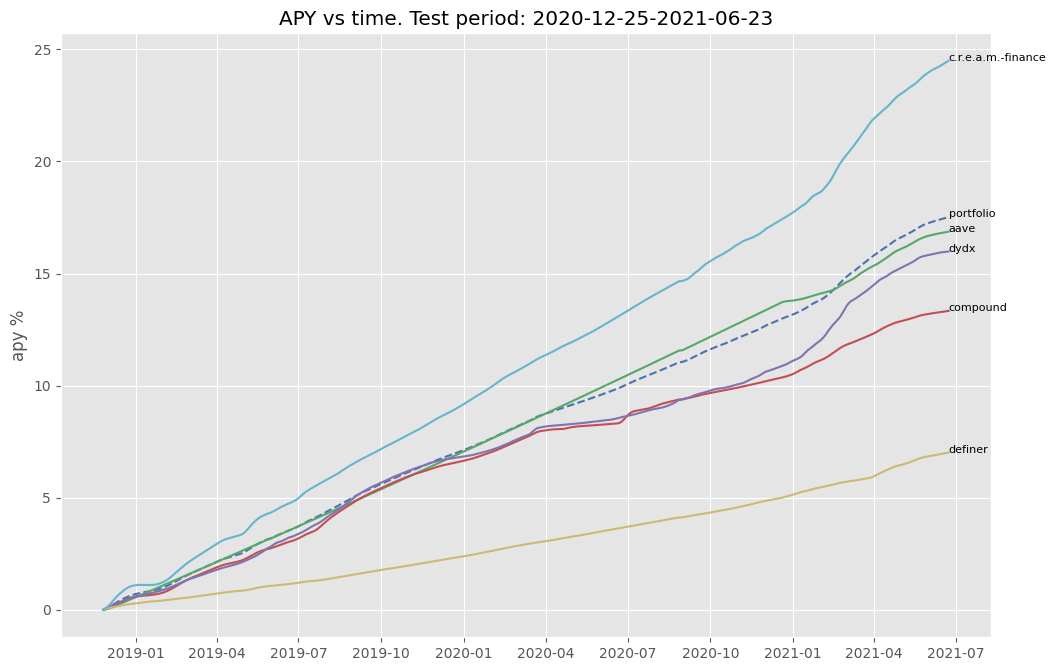

return in the test period 17.522198565336225


In [5]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from pypfopt.base_optimizer import portfolio_performance

def risk1_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] >= 0.1)
        ef.add_constraint(lambda w: w[i] <= 0.3)

risk1_weights, risk1_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=1, 
                                   target_volatility=0.05, 
                                   constraints_fn=risk1_constraints)

## BTC - ETH Portfolio

In [6]:
btceth_df = asset_prices_df[["btc", "eth"]]
train_df = btceth_df[btceth_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = btceth_df[(btceth_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (btceth_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

btceth_df.tail()


asset_ticker,btc,eth
2021-08-26,48655.290916,3231.255644
2021-08-27,48724.438920,3228.134696
2021-08-28,48708.328164,3226.787495
2021-08-29,48708.735036,3229.848890
2021-08-30,48555.745923,3233.449858


mean (yearly) return:
asset_ticker
btc    1.247571
eth    1.159752
dtype: float64

---portfolio weights---
OrderedDict([('btc', 0.5), ('eth', 0.5)])


Expected annual return: 120.4%
Annual volatility: 29.2%
Sharpe Ratio: 4.06


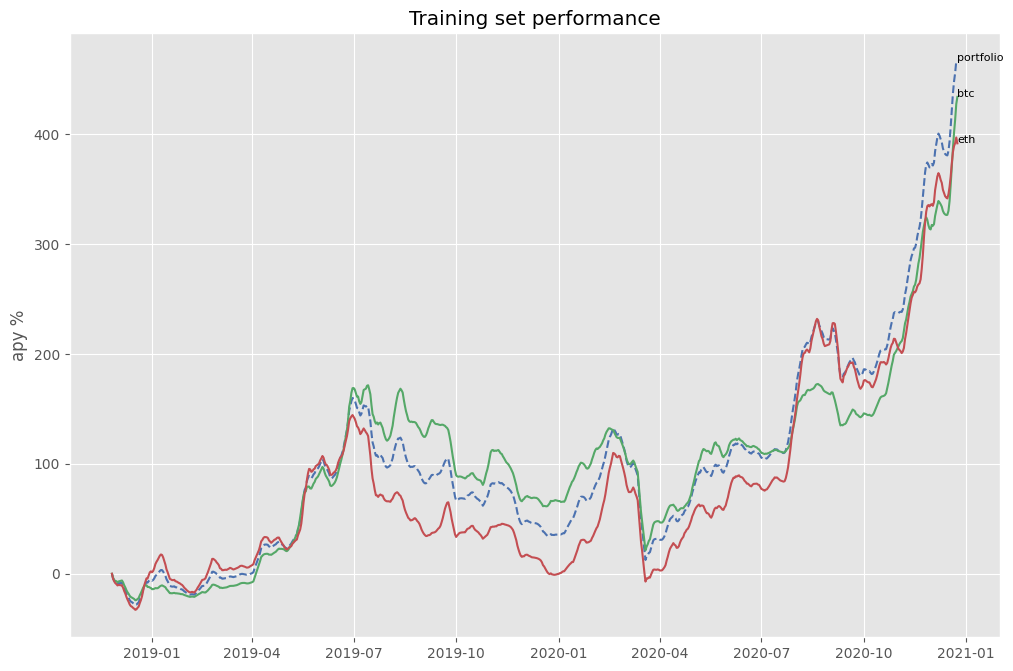

Expected annual return: 163.5%
Annual volatility: 31.4%
Sharpe Ratio: 5.15


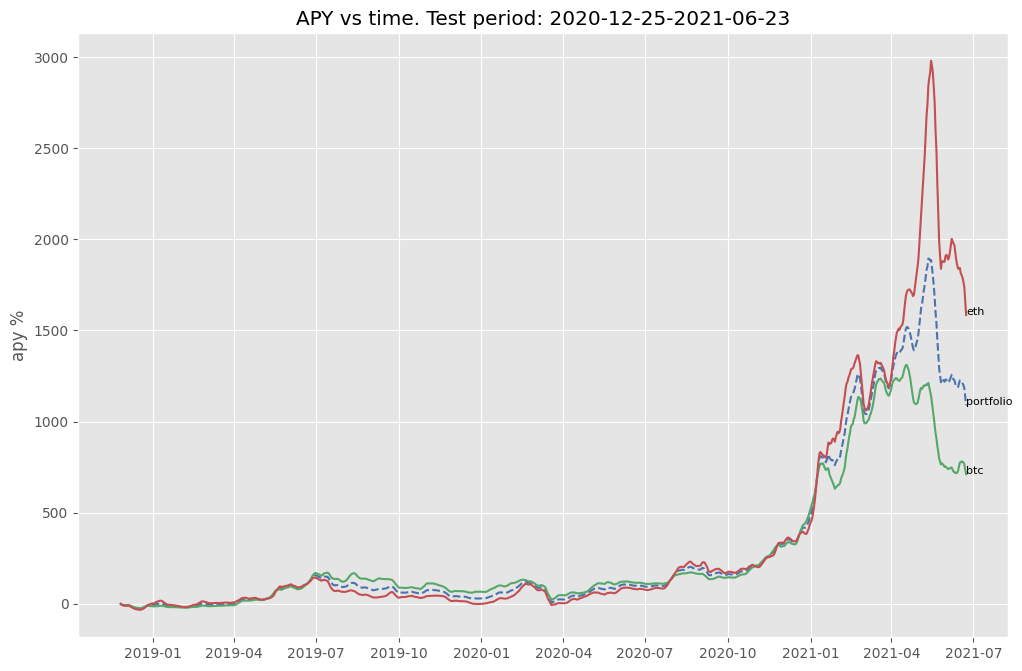

return in the test period 1088.7473439928044


In [7]:
def risk2_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] >= 0.5)
#         ef.add_constraint(lambda w: w[i] <= 0.3)

risk2_weights, risk2_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=90, 
                                   target_volatility=None, 
                                   constraints_fn=risk2_constraints)

## Top 10 Alt Coins by Market Cap Portfolio in Jan 2019

In [8]:
alt_coins_df = asset_prices_df[["xrp", "bch", "eos", "xlm", "ltc", 
                                "bsv", "trx", "ada", "miota", "xmr"]]
train_df = alt_coins_df[alt_coins_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = alt_coins_df[(alt_coins_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (alt_coins_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

alt_coins_df.tail()


asset_ticker,xrp,bch,eos,xlm,ltc,bsv,trx,ada,miota,xmr
2021-08-26,1.207655,666.128628,5.332281,0.368943,180.388870,164.503627,0.087892,2.607111,1.094799,296.864579
2021-08-27,1.194836,660.446028,5.280574,0.365533,179.634049,164.099536,0.087428,2.648241,1.087075,301.752112
2021-08-28,1.183715,652.008805,5.225992,0.361478,178.571767,162.463589,0.087179,2.716627,1.077386,306.434727
2021-08-29,1.173536,647.411162,5.175867,0.358054,177.913782,162.069560,0.087238,2.775562,1.068834,308.156089
2021-08-30,1.160815,644.028316,5.114785,0.353777,176.058598,162.269476,0.087254,2.796787,1.046520,306.455269


mean (yearly) return:
asset_ticker
xrp      0.088193
bch      0.210038
eos     -0.101083
xlm     -0.047163
ltc      0.790772
bsv      0.670531
trx      0.443259
ada      0.843995
miota   -0.000710
xmr      0.501845
dtype: float64

---portfolio weights---
OrderedDict([('xrp', 0.2),
             ('bch', 0.05),
             ('eos', 0.05),
             ('xlm', 0.05),
             ('ltc', 0.1),
             ('bsv', 0.05),
             ('trx', 0.2),
             ('ada', 0.05),
             ('miota', 0.05),
             ('xmr', 0.2)])


Expected annual return: 36.5%
Annual volatility: 30.5%
Sharpe Ratio: 1.13


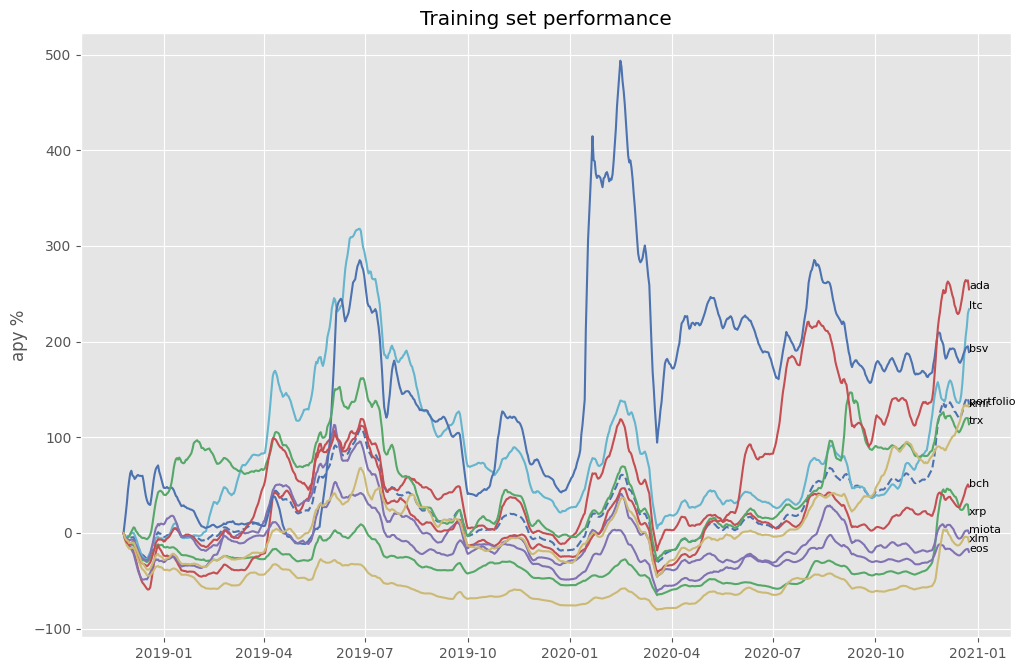

Expected annual return: 65.1%
Annual volatility: 35.1%
Sharpe Ratio: 1.80


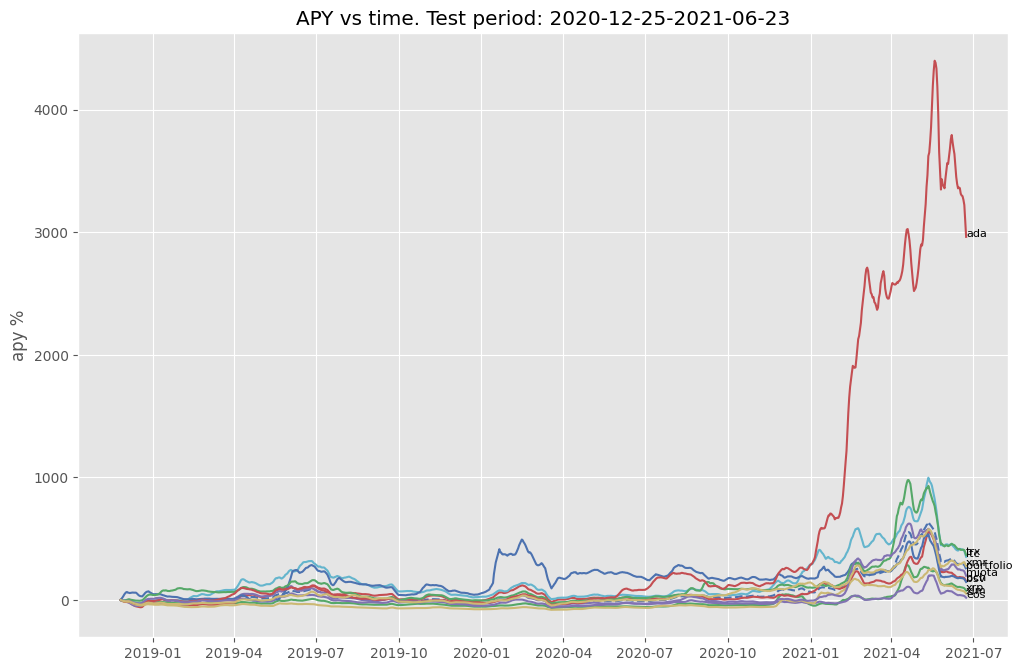

return in the test period 251.254726165075


In [9]:
def risk3_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] >= 0.05)
        ef.add_constraint(lambda w: w[i] <= 0.20)

risk3_weights, risk3_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=30, 
                                   target_volatility=None, 
                                   constraints_fn=risk3_constraints)

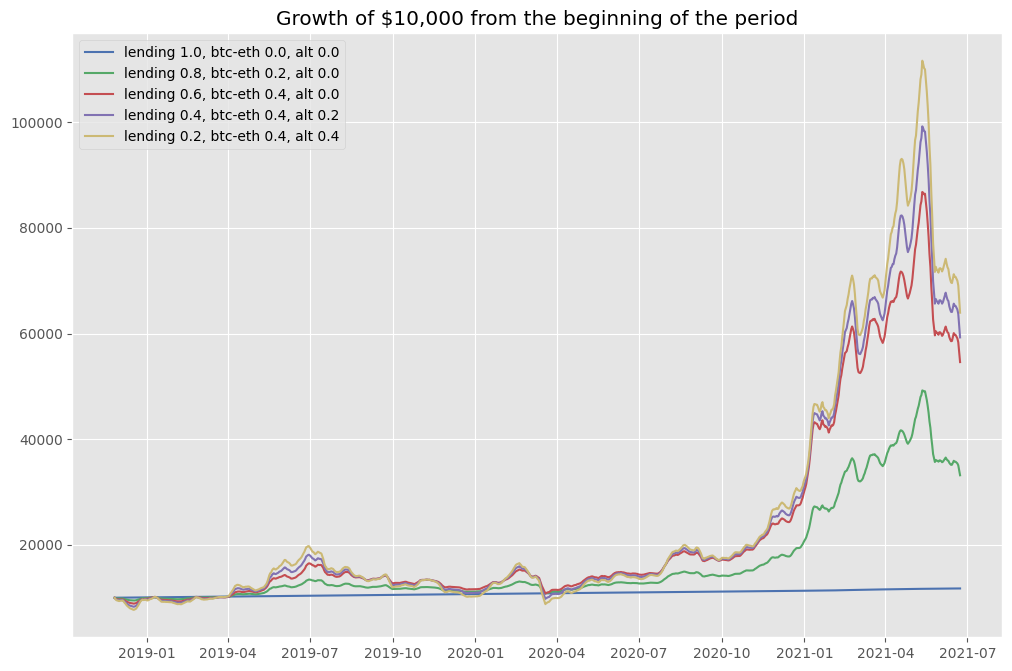

In [10]:
def mix_asset_portfolios(rois, allocations, init_investment=10000):
    portfolio_roi = sum([
        (1+np.array(roi)/100) * allocation * init_investment for roi, allocation in zip(rois, allocations)
    ])
    return portfolio_roi

rois = [risk1_roi, risk2_roi, risk3_roi]
portfolio_allocations = [[1., 0.0, 0.0],
                  [.80, 0.20, 0.0],
                  [.60, 0.40, 0.0],
                  [.40, 0.40, 0.20],
                  [.20, 0.40, 0.4]
                 ]
portfolio_rois = [mix_asset_portfolios(rois, alloc) for alloc in portfolio_allocations]

# print(len(test_df.index), len(risk1_roi))
for i, roi in enumerate(portfolio_rois):
    lending, btc_eth, alt = portfolio_allocations[i]
    plt.plot(test_df.index, roi, label=f"lending {lending}, btc-eth {btc_eth}, alt {alt}")
    plt.legend()
    plt.title("Growth of $10,000 from the beginning of the period")